**CSCI 4831: Sabermetrics Final Project**  
Name: Adam Ten Hoeve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In this juptyer notebook, we will attempt to calculate a statistic for batter-pitcher matchups, similar to an elo ranking, that we can then use to predict the outcome of future matchups. We will be using statcast data from 2016 - 2018 to get a wide range of pitcher and batters, as well as enough at-bats for each batter-pitcher pair to get reasonable outcome probabilities.

In [2]:
# Read in all of the statcast data
df2016 = pd.read_csv("2016/data2016.csv")

april2017 = pd.read_csv("2017/dataApril2017.csv")
may2017 = pd.read_csv("2017/dataMay2017.csv")
june2017 = pd.read_csv("2017/dataJune2017.csv")
july2017 = pd.read_csv("2017/dataJuly2017.csv")
aug2017 = pd.read_csv("2017/dataAug2017.csv")
sept2017 = pd.read_csv("2017/dataSept2017.csv")
oct2017 = pd.read_csv("2017/dataOct2017.csv")

april2018 = pd.read_csv("2018/dataApril2018.csv")
may2018 = pd.read_csv("2018/dataMay2018.csv")
june2018 = pd.read_csv("2018/dataJune2018.csv")
july2018 = pd.read_csv("2018/dataJuly2018.csv")
aug2018 = pd.read_csv("2018/dataAug2018.csv")
sept2018 = pd.read_csv("2018/dataSept2018.csv")
oct2018 = pd.read_csv("2018/dataOct2018.csv")

df2017 = pd.concat([april2017, may2017, june2017, july2017, aug2017, sept2017, oct2017])
df2018 = pd.concat([april2018, may2018, june2018, july2018, aug2018, sept2018, oct2018])

dfTotal = pd.concat([df2016, df2017, df2018])
# dfTotal = df2018.copy()

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A futur

First off, we need to clean the data. Lets get rid of anyone that has less that 100 pitches or 100 at-bats. This should significantly reduce the size of the data by getting rid of the all the extraneous batters and pitchers who don't have significant numbers around them.

In [3]:
# Clean the data. 
# Group by pitcher. Get rid of anyone who pitched less than 100 times in the three years.
dfTempPitch = dfTotal.groupby("player_name", as_index = False).count()
dfTempPitch = dfTempPitch.loc[dfTempPitch["index"] > 100]
# Then group by batter to get rid of any batters who batted less than 100 times.
dfTempBat = dfTotal.groupby("batter", as_index = False).count()
dfTempBat = dfTempBat.loc[dfTempBat["index"] > 100]

# Create a database of pitchers 
dfPitchers = pd.merge(dfTotal, dfTempPitch[["player_name"]], on = "player_name", how = "inner")
# Create a database of batters
dfBatters = pd.merge(dfTotal, dfTempBat[["batter"]], on = "batter", how = "inner")

# Create a final dataframe of the cleaned batter and pitcher data
dfFinal = pd.merge(dfPitchers, dfBatters[["index", "pitcher", "batter", "release_speed", "strikes", "balls"]], on = ["index", "pitcher", "batter", "release_speed", "strikes", "balls"], how = "inner")

Now, we want to look at the outcome of the plate appearance to determine if the pitcher or the batter "wins." Thankfully, Statcast has an "events" column that records significant events during that plate appearance. Because we don't need to know the events that led up to the eventual outcome of the plate appearance, we can again reduce the size of our data by getting rid of any columns that do not have an event tag. Note that we are ignoring some events in the data such as stolen bases as they do not directly correlate to that batter-pitcher matchup.

In [4]:
# A list of events of the batter either striking out or hitting the ball into play.
events = ["strikeout", "strikeout_double_play", "single", "double", "triple", "home_run", "sac_bunt", "sac_fly", "field_out", "field_error", "double_play", "grounded_into_double_play", "sac_fly_double_play", "triple_play", "walk", "hit_by_pitch"]
# Get rid of all the rows of data that don't have one of the events listed.
Outcomes = dfFinal.loc[dfFinal["events"].isin(events)]

In order to get a better idea about the outcomes of the plate appearances, let's calculate the proportion of each type of event.

In [5]:
# Calculate the proportion of each type of event. Will be used to calculate the weight of certain outcomes.
OutcomesProp = Outcomes.groupby("events", as_index = False).count()
numEvents = len(Outcomes)
OutcomesProp["proportion"] = OutcomesProp["index"] / numEvents
OutcomesProp = OutcomesProp[["events", "index", "proportion"]]
OutcomesProp

,events,index,proportion
0,double,24415,0.046200
1,double_play,1306,0.002471
2,field_error,4635,0.008771
3,field_out,216922,0.410475
4,grounded_into_double_play,10725,0.020295
5,hit_by_pitch,5231,0.009898
6,home_run,16975,0.032121
7,sac_bunt,2532,0.004791
8,sac_fly,3492,0.006608
9,sac_fly_double_play,56,0.000106


From this table, we can see that the majority of outcomes are field outs, which are a win for the pitcher. Following after are strikeouts and singles. Something important to note from this table is that the ratio of pitcher wins to batter wins is very skewed towards the pitcher because of that high percentage of field outs. We can see that, with that in the data, pitchers win about 65%-70% of the time. If we were to ignore field outs from the calculation, then pitchers would only win 30%-35% of the time. This skew in the data could have a large impact on the resulting elo calculations.

Now that we have our cleaned data, we can start calculating elo scores for the players. We will start by initializing two libraries to hold our elo scores, one of pitchers and one of batters. The player's ID will be the key and their score is the value. Like in the elo equations from chess, we will initizialize the values to 1000. This value will change as we begin to iterate over the data. Later, we will create another dictionary to hold counts of the actual results of the plate appearances. This will be used to test against our elo ranking system later.

In [44]:
# Create a dictionary of all batters and pitchers
batterElos = {}
pitcherElos = {}

# ids = list(Outcomes["pitcher"].unique()) + list(Outcomes["batter"].unique())
for id in list(Outcomes["pitcher"].unique()):
    pitcherElos[id] = 1000
for id in list(Outcomes["batter"].unique()):
    batterElos[id] = 1000
    
histResults = {}
    
# Create a list of pitcher-favored outcomes.
pitcherFavored = ["strikeout", "strikeout_double_play", "field_out", "double_play", "grounded_into_double_play", "sac_fly_double_play", "triple_play"]
# Create a list of batter favored outcomes, meaning they did not get out by the end of the play.
batterFavored = ["single", "double", "triple", "home_run", "field_error", "walk", "hit_by_pitch", "sac_bunt", "sac_fly"]

Now, as mentioned earlier, the pitchers win about 60%-65% of the matchups. This is a problem for the normal elo ranking system. In chess, which elo was first designed for, if two players of equal ranking faced each other, then each player should have an equal chance of winning the match. In baseball, this is not true. Because of the inherent advantage of the defense as seen in the data, if a pitcher and a batter of equal skill were to face off, then the pitcher would win the plate appearance 60%-65% of the time. This makes calculating elo rankings much more difficult. Below are a few ways I tried to adjust for this in the calculations.

The first way is the simplist, which weights scores based on the probability of winning. Basically, the decreased chance of a batter winning is counteracted by the batters winning more points when they do win. This weight is such that it gets the percieved outcome proportions to about 50% for batters, 50% for pitchers. For example, if a batter loses the plate appearance and would lose 10 points, instead they lose 8 points because they were more likely to lose. But if the batter won, instead of winning 10 pionts, they would actually win 12 points, again because they were less likely to win. The pitcher's score always changes by the same amount as the batter's.

The second way is much more complicated and did not work at all, but I thought it would I would keep it in to show what I tried. The second way doesn't weight the overall outcome, but rather specific events, similar to wOBA. In this way, if the batter scored a home run, they would get more points than if they scored a single. Again, this was aimed at getting the eventual probabilies to be about 50% for each. And this was really hard. There was far too many moving parts, it didn't improve the calculated predictions and it felt more like I was guessing at weights rather than using proper statistics. 

The last main way that I tried was using transformations to unskew the data. After testing methods like logarithms, square roots, centering and scaling, nothing seemed to yield tangible results.

In [45]:
def PercentOnBase(row):
    if row["events"] in batterFavored:
        return 1
    return 0

# Find how often batters get on base
total = len(Outcomes)
propBatterWins = np.sum(Outcomes.apply(PercentOnBase, axis = 1)) / total
propPitchWins = 1 - propBatterWins

print("Proportion of batter wins to pitcher wins:", propBatterWins, ":", propPitchWins)

# Batters only "win" about 35% of the time. So weight the eventual scores so it's as if they win 50% of the time.
# Way better than the old system of weighting scores individually
batterWeight = 0.5 / propBatterWins
pitcherWeight = 0.5 / propPitchWins

print("Weights calculated to make win proportions about 50%. Batter:", batterWeight," Pitcher:", pitcherWeight)

Proportion of batter wins to pitcher wins: 0.3442605579166872 : 0.6557394420833128
Weights calculated to make win proportions about 50%. Batter: 1.4523882812070577  Pitcher: 0.7624979800078492


In [46]:
# Determines the weight on the elo based on the type of event.
# Used to balance the proportion of pitcher-wins to batter-wins.
# Otherwise pitchers win about 70% of the time and dominate the scores
def EloEventWeight(event):
    # If that event occured
    if event == "strikeout":
        # Return the prob of that event times the assigned weight based on impact
        # All weights have are *2 what they normally are to speed up processing by preventing floating point arithmetic.
        return OutcomesProp.loc[OutcomesProp["events"] == "strikeout"]["proportion"] * 2
    elif event == "field_out":
        return OutcomesProp.loc[OutcomesProp["events"] == "field_out"]["proportion"] * 1
    elif event == "double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "double_play"]["proportion"] * 4
    elif event == "grounded_into_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "grounded_into_double_play"]["proportion"] * 4
    elif event == "strikeout_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "strikeout_double_play"]["proportion"] * 4
    elif event == "triple_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "triple_play"]["proportion"] * 6
    elif event == "sac_fly_double_play":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_fly_double_play"]["proportion"] * 2
    elif event == "single":
        return OutcomesProp.loc[OutcomesProp["events"] == "single"]["proportion"] * 2
    elif event == "double":
        return OutcomesProp.loc[OutcomesProp["events"] == "double"]["proportion"] * 4
    elif event == "triple":
        return OutcomesProp.loc[OutcomesProp["events"] == "triple"]["proportion"] * 6
    elif event == "home_run":
        return OutcomesProp.loc[OutcomesProp["events"] == "home_run"]["proportion"] * 8
    elif event == "sac_bunt":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_bunt"]["proportion"] * 2
    elif event == "sac_fly":
        return OutcomesProp.loc[OutcomesProp["events"] == "sac_fly"]["proportion"] * 2
    elif event == "field_error":
        return OutcomesProp.loc[OutcomesProp["events"] == "field_error"]["proportion"] * 2
    elif event == "walk":
        return OutcomesProp.loc[OutcomesProp["events"] == "walk"]["proportion"] * 2
    elif event == "hit_by_pitch":
        return OutcomesProp.loc[OutcomesProp["events"] == "hit_by_pitch"]["proportion"] * 2
    else:
        # something got through that wasn't supposed to get through
        print(event)
        return 0

We have our data and our libraries, we now need to apply our ranking system. Below is the first equation in the elo system. It follows the form:

$$ P(\text{pitcher wins}) = \dfrac{1}{(1 + 10^{(R_B - R_P)/1000})} $$

where $R_B$ is the batter's rank and $R_P$ is the pitcher's rank. In this form, a player that has 1000 more points than another player is 10 times more likely to win the matchup.

The second equation we need is a way to update scores base on the outcomes of the matches. This equation is:

$$ \text{New Rating} = \text{Rating} + 32(\text{outcome} - \text{probability of outcome}) $$

where the outcome is either a 0 or 1, whether they won or lost, and the probability of the outcome comes from the first equation. The 32 is the maximum amount a value can change in a single plate appearance. We will define these equations as functions then we can apply our elo ranking system to the statcast data.

In [47]:
# Create a function to calculate the probability a pitcher wins the matchup
def ProbPitcherWins(pitcher, batter):
    # Get ranking of pitcher and batter
    pitcherRank = pitcherElos[pitcher]
    batterRank = batterElos[batter]
    # From elo rankings. Assumes a difference of 400 is the same as 1 player being 10 times as likely to win
    probPitcherWins = 1 / (1 + 10**((batterRank - pitcherRank)/1000))
    return probPitcherWins

In [48]:
# Function to update the scores of players based on the results of pitches
def UpdateElo(row):
    p = row["pitcher"]
    b = row["batter"]
    # Get the probability that the pitcher wins from the function above
    prob = ProbPitcherWins(p, b)
    
    # Add the matchup to the dictionary if it doesn't exist
    if (p, b) not in histResults.keys():
        histResults[(p, b)] = np.array([0, 0])
    
    # Update the ratings based on the outcome of the pitch
    # If pitcher "wins" the matchup
    if row["events"] in pitcherFavored:
        # Weighted to get outcome proportions to 50%
        pitcherElos[p] = np.floor(pitcherElos[p] + (32 * pitcherWeight * (1 - prob)))
        batterElos[b] = np.floor(batterElos[b] + (32 * pitcherWeight * (prob - 1)))
        # Weighted by each type of outcome
#         pitcherElos[p] = np.floor(pitcherElos[p] + (16 * EloEventWeight(row["events"]) * (1 - prob)))
#         batterElos[p] = np.floor(batterElos[b] + (16 * EloEventWeight(row["events"]) * (prob - 1)))
        # Unweighted Outcomes
#         pitcherElos[p] = np.floor(pitcherElos[p] + (32 * (1 - prob)))
#         batterElos[b] = np.floor(batterElos[b] + (32 * (prob - 1)))
        histResults[(p, b)] = histResults[(p, b)] + np.array([1, 0])
    # If the batter wins the matchup
    else:
        # Weighted to get outcome proportions to 50%
        pitcherElos[p] = np.floor(pitcherElos[p] + (32 * batterWeight * (prob - 1)))
        batterElos[b] = np.floor(batterElos[b] + (32 * batterWeight * (1 - prob)))
        # Weighted by type of outcome
#         pitcherElos[p] = np.floor(pitcherElos[p] + (16 * EloEventWeight(row["events"]) * (prob - 1)))
#         batterElos[p] = np.floor(batterElos[b] + (16 * EloEventWeight(row["events"]) * (1 - prob)))
        # Unweighted
#         pitcherElos[p] = np.floor(pitcherElos[p] + (32 * (prob - 1)))
#         batterElos[b] = np.floor(batterElos[b] + (32 * (1 - prob)))
        histResults[(p, b)] = histResults[(p, b)] + np.array([0, 1])

We then apply these functions to every row in our dataset, as every row is an at bat. This will calculate the probability each player wins, update both player's score based on the difference between the result and the expected outcome probability, and store that new score in the library. For the later data analysis, I would recommend uncommenting a section and rerunning the apply function below to see how they affect the resulting scores.

In [49]:
Outcomes.apply(UpdateElo, axis = 1);

In [77]:
# Find the batters with the highest elo
maxElos = [0] * 10
maxPlayers = [0] * 10
for i in batterElos:
    if(batterElos[i] > min(maxElos)):
        minIndex = maxElos.index(min(maxElos))
        maxPlayers[minIndex] = i
        maxElos[minIndex] = batterElos[i]

In [78]:
from pybaseball import playerid_reverse_lookup

dataB = playerid_reverse_lookup(maxPlayers, key_type='mlbam')
dataB["elo"] = 0
for player in maxPlayers:
    dataB.loc[dataB["key_mlbam"] == player, "elo"] = batterElos[player]
dataB

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,elo
0,altuve,jose,514888,altuj001,altuvjo01,5417,2011.0,2019.0,9563.0
1,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0,7071.0
2,bryant,kris,592178,bryak001,bryankr01,15429,2015.0,2019.0,7738.0
3,goldschmidt,paul,502671,goldp001,goldspa01,9218,2011.0,2019.0,8725.0
4,lemahieu,dj,518934,lemad001,lemahdj01,9874,2011.0,2019.0,6938.0
5,martinez,j. d.,502110,martj006,martijd02,6184,2011.0,2019.0,7383.0
6,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0,12848.0
7,turner,justin,457759,turnj001,turneju01,5235,2009.0,2019.0,7139.0
8,votto,joey,458015,vottj001,vottojo01,4314,2007.0,2019.0,12618.0
9,yelich,christian,592885,yelic001,yelicch01,11477,2013.0,2019.0,6928.0


In [76]:
# Find the pitchers with the highest elo
maxElos = [0] * 10
maxPitchers = [0] * 10
for i in pitcherElos:
    if(pitcherElos[i] > min(maxElos)):
        minIndex = maxElos.index(min(maxElos))
        maxPitchers[minIndex] = i
        maxElos[minIndex] = pitcherElos[i]
        
data = playerid_reverse_lookup(maxPitchers, key_type='mlbam')
data["elo"] = 0
for pitcher in maxPitchers:
    data.loc[data["key_mlbam"] == pitcher, "elo"] = pitcherElos[pitcher]
data

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,elo
0,buehler,walker,621111,buehw001,buehlwa01,19374,2017.0,2019.0,1789.0
1,degrom,jacob,594798,degrj001,degroja01,10954,2014.0,2019.0,1877.0
2,greinke,zack,425844,greiz001,greinza01,1943,2004.0,2019.0,1715.0
3,hader,josh,623352,hadej001,haderjo01,14212,2017.0,2019.0,1901.0
4,jansen,kenley,445276,jansk001,janseke01,3096,2010.0,2019.0,2026.0
5,kluber,corey,446372,klubc001,klubeco01,2429,2011.0,2019.0,1821.0
6,osuna,roberto,532077,osunr001,osunaro01,13764,2015.0,2019.0,1791.0
7,sale,chris,519242,salec001,salech01,10603,2010.0,2019.0,1816.0
8,scherzer,max,453286,schem001,scherma01,3137,2008.0,2019.0,2441.0
9,verlander,justin,434378,verlj001,verlaju01,8700,2005.0,2019.0,1915.0


Now that we have our scores, we can compute predictions for specific batter-pitcher matchups using the same equation that we used to calculate the probabilities to update the scores. Let's test a few.

In [54]:
def PredictWinner(pitcherID, batterID):
    # Get the elos of both players
    probPWins = ProbPitcherWins(pitcherID, batterID)
    print("Batter Elo:", batterElos[batterID])
    print("Pitcher Elo:", pitcherElos[pitcherID])
    print("The probability that the pitcher wins is", probPWins)
    
    # Find the actual historical data on who won the at-bat
    histData = histResults[(pitcherID, batterID)]
    percentPWon = histData[0] / np.sum(histData)
    if(np.isnan(percentPWon)):
        percentPWon = 0
    print("The percentage of at-bat appearances the pitcher won is", percentPWon)

In [55]:
histResults[("a")] = 0

# To make sure there is no bias, let's calculate scores of random matchups
num = 5
matchups = np.random.choice(list(histResults.keys()), size = num)

for i in matchups:
    PredictWinner(i[0], i[1])

Batter Elo: 501.0
Pitcher Elo: -2340.0
The probability that the pitcher wins is 0.0014400386496813734
The percentage of at-bat appearances the pitcher won is 0.5
Batter Elo: 398.0
Pitcher Elo: -678.0
The probability that the pitcher wins is 0.07744481621440553
The percentage of at-bat appearances the pitcher won is 0.6666666666666666
Batter Elo: 1095.0
Pitcher Elo: 583.0
The probability that the pitcher wins is 0.23524579684000338
The percentage of at-bat appearances the pitcher won is 0.0
Batter Elo: 1038.0
Pitcher Elo: -4297.0
The probability that the pitcher wins is 4.623788834470563e-06
The percentage of at-bat appearances the pitcher won is 0.0
Batter Elo: 939.0
Pitcher Elo: 489.0
The probability that the pitcher wins is 0.2618909674595814
The percentage of at-bat appearances the pitcher won is 0.0


We can also plot some things to get a better look at the range of scores. From theory, the overall distribution of scores should follow a guassian. However, when we perform the calculations, the histograms are not normal. 

Without weights, the histograms look almost uniform. The scores for the batters range from about [0, 1000] and the scores for pitchers range from about [1000, 2000].

With the simple weights, the histograms look more normal with means around the 1,000 mark, but very skewed. The batter's data is left skewed with a tail that goes all the way out to almost 5,000 and the pitcher's data is right skewed with a tail that reaches -2,000. When we plot the total scores, the data has a vast majority clusted from [0, 1500] which dies down quickly with some very long tails.

Text(0.5,1,'Pitcher Elo Scores')

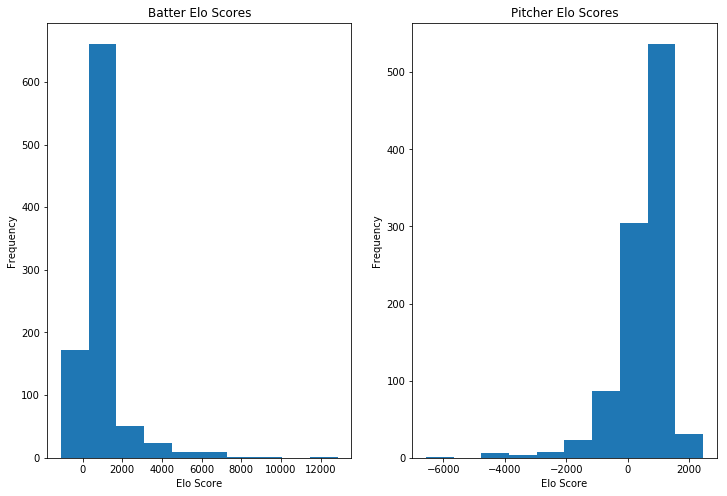

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].hist(batterElos.values())
ax[0].set_xlabel("Elo Score")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Batter Elo Scores")
ax[1].hist(pitcherElos.values())
ax[1].set_xlabel("Elo Score")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Pitcher Elo Scores")

Text(0.5,1,'Pitcher Elo Scores')

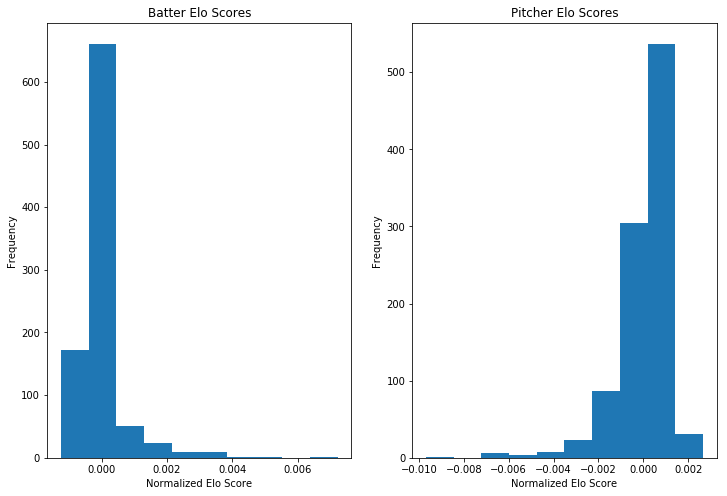

In [57]:
# Scale the data so mean is 0 and variance is 1
bats = list(batterElos.values())
meanBats = np.mean(bats)
varBats = np.var(bats)
newBats = (bats - meanBats) / varBats

pits = list(pitcherElos.values())
meanPits = np.mean(pits)
varPits = np.var(pits)
newPits = (pits - meanPits) / varPits

fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].hist(newBats)
ax[0].set_xlabel("Normalized Elo Score")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Batter Elo Scores")
ax[1].hist(newPits)
ax[1].set_xlabel("Normalized Elo Score")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Pitcher Elo Scores")

Text(0,0.5,'Frequency')

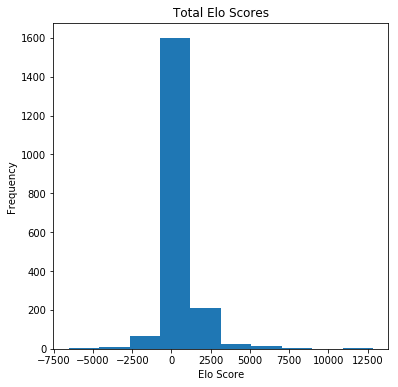

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
total = list(batterElos.values()) + list(pitcherElos.values())
ax.hist(total)
ax.set_title("Total Elo Scores")
ax.set_xlabel("Elo Score")
ax.set_ylabel("Frequency")

In conclusion, I am glad I did the elo rankings. It helped me get a better understanding of statistical transformations, and a better idea of how ranking systems should be planned out. In hindsight, it doesn't make much sense to use an individual scoreing system for a team sport, but the investigation was still worthwhile. 